# Demonstrations of Attention

This notebook demonstrates the attention mechanism in the transformer model, such as the GPT-X models. And is meant to be as lecture notes for the course.

It's motivated by the tutorial from Andrej Karpathy ( 
[youtube](https://www.youtube.com/watch?v=kCc8FmEb1nY&t=5191s), [code](https://github.com/karpathy/ng-video-lecture/blob/master/gpt.py)) but we use numpy here and just explain the intuition and the foreward pass. Another good source is his guest lecture at Stanford [youtube](https://youtu.be/XfpMkf4rD6E?si=_qjYgLXL-BVZjWc-&t=1388)

##  Dimensions and Intuition


We are looking at word embeddings $\vec{x}_i$ of dimension $\mathbb{R}^C$. The index $i=1 \ldots T$ is the position of the word in a sentence. 

Example:
```text
Emma hates games but she is a  great friend.
```
$$ 
\vec{x}_1, \vec{x}_2,\vec{x}_3,\vec{x}_4,\vec{x}_5,\vec{x}_6,\vec{x}_7,\vec{x}_7,\vec{x}_8,\vec{x}_9
$$

The word "friend" is at position $i=9$ not all words are equally important for that word. For example the word "friend" strongly depends on the word "Emma" but not so much on the word "hates". We will derive a weight matrix $W_{\text{to}, \text{from} }$. In this example we would expect $W_{9,1} \gg W_{9,2}$.

##### Tensors for efficient computation
To work efficiently with tensors, we use batch processing. The complete input $x$ is a tensor of dimension $\mathbb{R}^{B \times T \times C}$.

In [81]:
import numpy as np
np.random.seed(1)
B,T,C = 2, 9, 4
x = np.random.normal(size=(B,T,C))
x.shape
np.round(x[0], 2)

array([[ 1.62, -0.61, -0.53, -1.07],
       [ 0.87, -2.3 ,  1.74, -0.76],
       [ 0.32, -0.25,  1.46, -2.06],
       [-0.32, -0.38,  1.13, -1.1 ],
       [-0.17, -0.88,  0.04,  0.58],
       [-1.1 ,  1.14,  0.9 ,  0.5 ],
       [ 0.9 , -0.68, -0.12, -0.94],
       [-0.27,  0.53, -0.69, -0.4 ],
       [-0.69, -0.85, -0.67, -0.01]])

### A (side) Note on Tensor Dimensions and the Einstein summation 
The complete input $x$ is a tensor of dimension $\mathbb{R}^{B \times T \times C}$.

Since we work in at least a 3-dimensional space, talking about operations like transposing or matrix multiplication can be a bit confusing. 
A more intuitive way to think about matrix multiplication in this setting is by considering it as a summing-out operation. For instance, if we have two matrices $ A $ and $ B $ of dimensions $ \mathbb{R}^{n \times k} $ and $ \mathbb{R}^{k \times m} $ respectively, then the matrix product is a matrix $ C $ of dimensions $ \mathbb{R}^{n \times m} $, defined as follows:

$$
C_{ij} = \sum_{l=1}^k A_{il} B_{lj}
$$

In this expression, we're **summing out** the shared dimension $ k $ to obtain the resulting matrix $ C $. This "summing out" is akin to the idea of "abspuren" or tracing out in tensor operations, where we reduce the dimensions by summing over one or more indices. There is a pattern, that the summing-out is done over adjacent indices. This is the idea of the Einstein summation convention, where we omit the summation symbol and assume that the summation is done over adjacent indices. For instance, the above expression can be written as:
$$
C_{ij} = A_{il} B_{lj}
$$
where the summation is implied over the index $ l $. So multiplying two matrices (N,K) and (K,M) results in a matrix of dimension (N,M). In numpy we can use this Einstein summation convention with the `einsum` function.

In [82]:
A = np.round(np.random.normal(size=(3,4)),1)
B = np.round(np.random.normal(size=(4,2)),1)
A @ B, np.einsum('ik,kj', A, B)


(array([[-2.96,  0.31],
        [ 0.36,  0.67],
        [ 0.6 ,  0.2 ]]),
 array([[-2.96,  0.31],
        [ 0.36,  0.67],
        [ 0.6 ,  0.2 ]]))

Note that $A B^\top$ is not a valid matrix multiplication, since the adjacent indices are not the same. We can however use the Einstein summation convention to express this operation as:

In [83]:
#np.einsum('ik,kj', A, B.T) # not working
np.einsum('ik,jk', A, B.T) # working and same as above

array([[-2.96,  0.31],
       [ 0.36,  0.67],
       [ 0.6 ,  0.2 ]])


#### General remarks about Tensors
When thinking of tensors it's better not (at least first) to think as matrices but as a multidimensional array, and try working in a 3-dimensional (or more dimensional) space. For effeciency it might be better to use matrix or vector operations.

#### The vector symbol 
We wrote $\vec{x}_9$ to denote a vector that, lives in the embedding space $C$. This is important to build intuition, for example the dot product is the similarity. 



### Query, Key 

To model this dependency, we introduce a query $\vec{q}^i$ and a key vectors $\vec{k}^j$ for each word. The idea about the query vector $\vec{q}^{i=9}$ is to let the word "friend" ask a question to all other words. This question is encoded in the query vector. The query vector might lives in a diffent space the the word embedding. In fact it does, and we will see later when talking about muti-head attention that this is quite convenient to set the dimension $m$ of the query vector is smaller than $C$. We obtain the $\vec{q}^i$ by a linear transformation (or a full connected NN) of the word embedding 

$$
    \vec{q}^i= W^q \vec{x}^i
$$ 


The key vector is the answer to the question. It's also a linear transformation of the word embedding $\vec{k}^i= W^k \vec{x}^i$. The querry and key vectors have the same dimension, instead of living in $\mathbb{R}^C$ these vectors live in $\mathbb{R}^m$. 
So we have $W^q , W^k \in \mathbb{R}^{m \times C}$. $m$ is called head size / dimension. Notation of the original paper 

* $m$ is also called $d_k$ 
* $C$ is called $d_\text{model}$ and they set $m=C/h$ with $h=8$.

### The query and key in tensor notation

Since x has the dimension (B,T,C) we can transform it to (B,T,m) by multiplying it with $W^q$ and $W^k$.

In [91]:
m = 8
wk = np.random.normal(size=(C, m))
K_einsum = np.einsum('btc, cm->btm', x, wk) # (B, T, C) * (C, m) = (B, T, m) note in this case we have to state the dimension of the output
K = np.matmul(x, wk) # (B, T, C) * (C, m) = (B, T, m)

wq = np.random.normal(size=(C, m))
Q = np.matmul(x, wq) # (B, T, C) * (C, m) = (B, T, m)
Q.shape, K.shape, np.allclose(K, K_einsum)

((2, 9, 8), (2, 9, 8), True)

### Similarity between Query and Key

The similarity between the key and the query is computed by the dot product $\vec{q}^i \cdot \vec{k}^j$. The dot is reduced over the $m$-dimension and is a similarity measure. The dot product is high if the vectors are pointing in the same direction. The dot product is low if the vectors are orthogonal. We get the dot product, for a given batch $b$ and a given position $t$ by 

$$
    z_{b,j, i} = \sum_m Q_{b,j,m} K_{b,i,m} 
$$

Viewed as a tensor $z$ is $z \in \mathbb{R}^{B \times T \times T}$. 

This quantity can be easily computed using the `np.einsum` function.

In [96]:
z = np.einsum('bjm,bim->bji', Q, K) 
z[1,2,3], z.shape

(6.015555366132908, (2, 9, 9))

####  As (batched) matrix multiplication

You often see this code in (batched) matrix notations. Therefore, you have to (kind of transpose K), yielding the dimensions

(B, T, m) * (B, m,  T)

In this case of each batch a standard matrix multiplication between (T,m) and (m,T) is performed for each member. In generally the two rightmost dimensions are used for the matrix multiplication.

I don't like it, because it's not clear what's going on. But it might be faster and if training your models costs millions of dollars, you might want to use this notation.

In [99]:
zd = Q @ K.swapaxes(-2,-1) # (B, T, m) * (B, m,  T) = (B, T, T)
Q.shape, K.swapaxes(-2,-1).shape, zd.shape, z[1,2,3], np.allclose(z, zd)

((2, 9, 8), (2, 8, 9), (2, 9, 9), 6.015555366132908, True)

### Softmax to be interpreted as weights

While the z holds the similarities between $i$ and $j$. We want to normalize it, so that it can be seen as a weight in a weighted average procedure. We normalize it by the softmax function.

In [98]:
# Unfortunately, softmax is not part of the numpy
def softmax(z, axis=-1):
    exp_z = np.exp(z - np.max(z, axis=axis, keepdims=True))  # Subtract max for numerical stability
    sum_exp_z = np.sum(exp_z, axis=axis, keepdims=True)
    softmax_output = exp_z / sum_exp_z
    return softmax_output

In [100]:
np.round(softmax(z)[0],2)

array([[0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.97, 0.01, 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.01],
       [0.  , 0.35, 0.35, 0.18, 0.  , 0.11, 0.  , 0.  , 0.  ],
       [0.57, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.43, 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.37, 0.07, 0.  , 0.  , 0.35, 0.09, 0.08, 0.03, 0.01],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]])

This matrix now reads contains the weights for each word (column) to each predecessor (row). Two addtions

#### Flattening the softmax
The softmax is a quite peacky function. Change $m$ in the code above, and you will see that the peakyness depends on $m$. So we divide by $\sqrt{m}$ to make it more flat. 

<details>
  <summary>Sidenote Scaling as Temperature</summary>

  Sidenote this is similar to the idea of temperature when sampling from LLM. 
</details>


In [57]:
np.round(softmax(z/np.sqrt(m))[0],2)

array([[0.32, 0.02, 0.09, 0.05, 0.04, 0.02, 0.17, 0.19, 0.1 ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.98],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.45, 0.55],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.8 ],
       [0.02, 0.69, 0.03, 0.06, 0.09, 0.01, 0.03, 0.01, 0.07],
       [0.03, 0.  , 0.03, 0.04, 0.03, 0.4 , 0.03, 0.35, 0.08],
       [0.12, 0.01, 0.03, 0.04, 0.05, 0.01, 0.1 , 0.24, 0.39],
       [0.09, 0.45, 0.1 , 0.07, 0.07, 0.11, 0.07, 0.02, 0.01],
       [0.  , 0.97, 0.  , 0.01, 0.02, 0.  , 0.  , 0.  , 0.  ]])

### Causal Mask

The second addition is the causal mask. When we use attention in the decoder, we sample word by word and don't want to look into the future. So we set all weights to zero that are not causal. We do this by setting the weights to $-\infty$ before the softmax. The softmax of $-\infty$ is zero. When using the attention in the encoder (for example in the Bart Language Model), you don't need to do the masking.

In [59]:
### Set the upper diagonal to -inf
upper_tri_indices = np.triu_indices(z.shape[1], k=1)
# Iterate over the first dimension of z
for i in range(z.shape[0]):
    # Set the upper triangular elements of each (9, 9) slice to -inf
    z[i][upper_tri_indices] = -np.inf

np.round(softmax(z/np.sqrt(m))[1],2)

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.98, 0.02, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.67, 0.02, 0.31, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.1 , 0.14, 0.06, 0.7 , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.27, 0.15, 0.53, 0.01, 0.05, 0.  , 0.  , 0.  , 0.  ],
       [0.03, 0.  , 0.01, 0.13, 0.  , 0.83, 0.  , 0.  , 0.  ],
       [0.03, 0.04, 0.02, 0.17, 0.09, 0.15, 0.49, 0.  , 0.  ],
       [0.08, 0.02, 0.01, 0.2 , 0.1 , 0.08, 0.49, 0.02, 0.  ],
       [0.03, 0.01, 0.09, 0.02, 0.  , 0.09, 0.  , 0.46, 0.29]])

## The Value

So far we have the strength of attention (weight) from a word $i$ to earlier words $j$. Now we need to compute the value. In the example of the weighted average the the value itself. The intuition in the Karpathy tutorial is that the value the public value broadcasted from the private $\vec{x}_i$.

The value is a linear transformation of the word embedding $\vec{v}^i= W^v \vec{x}^i$. In principle the value could have another dimension $d_v$ but they set it to $m$.

In [60]:
wv = np.random.normal(size=(C, m))
q = np.matmul(x, wv)
q.shape # (B, T, m)

(2, 9, 8)

### Putting it all together (a single self attention head)

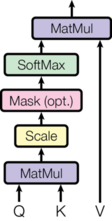
$$
x \in \mathbb{R}^{B,T,C} \rightarrow x^{new} = \text{softmax}\left(\frac{z}{\sqrt{m}}\right) \cdot {W^v} x \in \mathbb{R}^{B,T,m}
$$



So all in all we have three linear transformations $W^q, W^k, W^v$ with $3 \cdot m \cdot C$ parameters.


#### Multi Head Attention (Running several heads in parallel, wide)

In the transformers, we use multiple heads. Each of the $H$ head gets as input $x \in \mathbb{R}^{B,T,C}$ and outputs $x^{new} \in \mathbb{R}^{B,T,m}$. The heads are concatenated to a tensor of dimension $\mathbb{R}^{B,T,H m}$. 

In the paper, this output is again linearly transformed with a matrix $W^O$ to $\mathbb{R}^{B,T,C}$. Called projection in the youtube video.

A typical choice of $m$ is $C/H$. So that the the embedding dimension $C$ is preserved. In the notation of the paper $d_k=d_v=d_\text{model}/h = 64$ and they choose $h=8$.


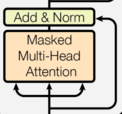

After all the multi-head transformer blocks takes and input of dimension $\mathbb{R}^{B,T,C}$ and outputs a tensor of dimension $\mathbb{R}^{B,T,C}$.


### Feed Foreward Network 


The feed forward is a two layer neural network with a ReLU activation inbetween. In the tutorial is is given by:

```python
self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        ) 
```

Motivation on the feed forward network. The attention mechanism tells which words are important for another word. Karpathy explains calls this communication. The feed forward network is the computation part. Note that the feed forward network is the same, shared for all words and applied independently to each word. This is weight sharing.

## Building the block

A hole block is then given by:

1. Layer Norm
2. Multi Head Attention
3. Residual Connection
4. Layer Norm
5. Feed Forward
6. Residual Connection

#### In code

The following is from the code of the youtube tutorial.

```python
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
```


#### In the paper
In the paper the block is shown as follows. 

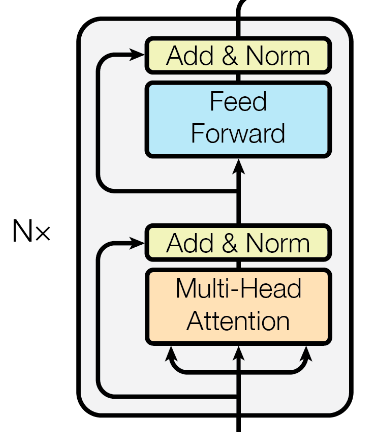

In contrast to the paper. 

1. Lower Part First the normalization (Norm) is done then the multihead attention and then the residual connection (add)
2. Upper Part First the normalization is done then Feed Forward and then the residual connection.

## All weights

For each Attention Block we have the following weights

* $w^q \in \mathbb{R}^{C \times m}$
* $w^r \in \mathbb{R}^{C \times m}$
* $w^v \in \mathbb{R}^{C \times m}$

If we have $H$ heads, and choose $m=C/H$, we have $3 \cdot H \cdot C / m \cdot m = 3 \cdot T \cdot H$ parameters.

A projetion adds another $(T, C)$ matrix. So the multihead attention block has $4 \cdot T \cdot C$ parameters. The feed forward network has a single hidden layer with dimension $d_\text{ff}$ and so $C \cdot d_\text{ff} \cdot 2$ parameters. So in total we have

$$
    4 \cdot T \cdot C + 2 \cdot C \cdot d_\text{ff}
$$

parameters per block.

In [66]:
#GPT-3 small
T = 2048  #Context Window Size 
C = 768   #Embedding Size called d_model in the paper
nlayer = 12 #Number of layers
dff = 4*C #Dimension of the feed forward network
num_per_block = 4*T*C+2*C*dff
num_per_block * nlayer

132120576

In [70]:
#GPT-3 175B
T = 2048    #Context Window Size 
C = 12288   #Embedding Size called d_model in the paper
nlayer = 96 #Number of layers
dff = 4*C #Dimension of the feed forward network
num_per_block = 4*T*C+2*C*dff
num_per_block * nlayer / 1e9

125.627793408